In [ ]:
!pip install Textacy

     |████████████████████████████████| 184kB 6.5MB/s 
     |████████████████████████████████| 102kB 4.8MB/s 
     |████████████████████████████████| 481kB 8.8MB/s 
     |████████████████████████████████| 1.9MB 11.1MB/s 
  Created wheel for cytoolz: filename=cytoolz-0.11.0-cp36-cp36m-linux_x86_64.whl size=1225606 sha256=9be6c9db4d98513fb5fd48fae91afc9969bf18f565086292982b549a9bb3b50d
  Stored in directory: /root/.cache/pip/wheels/a1/32/3c/9c9926b510647cacdde744b2c7acdf1ccd5896fbb7f8d5df0c
Successfully built cytoolz


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cd /content/drive/MyDrive/SCOTUS/input-files/

/content/drive/MyDrive/SCOTUS/input-files


In [ ]:
import pickle, sys
import logging
import os.path
from os import path
import nltk
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from gensim import corpora, models
from gensim.models import LdaModel, LdaMulticore
from sklearn import model_selection, naive_bayes, svm
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

import seaborn as sns
sns.set()

nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('punkt')
nltk.download('wordnet')

lemmatizer = WordNetLemmatizer()

import re
import pandas as pd
import textacy.datasets
import matplotlib.pyplot as plt
import numpy as np
import gensim
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [ ]:
def data_extraction():
    ds = textacy.datasets.SupremeCourt()
    ds.download()

    decisions = ds.records()
    scotus_issue_area = []
    scotus_issue = []
    scotus_text = []
    issue_freq = {}
    issue_area_freq = {}

    for text, details in decisions:
        if details['issue_area'] == -1:
            continue
        if details['issue'] == 'none':
            continue

        scotus_issue_area.append(details['issue_area'])
        scotus_issue.append(details['issue'])
        scotus_text.append(text)

        if details['issue'] in issue_freq:
            issue_freq[details['issue']] = issue_freq[details['issue']] + 1
        else:
            issue_freq[details['issue']] = 1

        if details['issue_area'] in issue_area_freq:
            issue_area_freq[details['issue_area']] = issue_area_freq[details['issue_area']] + 1
        else:
            issue_area_freq[details['issue_area']] = 1

    plot_issue_freq(issue_freq, issue_area_freq)
    return ds, decisions, scotus_issue_area, scotus_issue, scotus_text, issue_freq, issue_area_freq

In [ ]:
def plot_issue_freq(issue_freq, issue_area_freq):
    fig, ax = plt.subplots(2, figsize=[20.0, 8.0])
    issue_area_freq.plot.bar(y='Docs', ax = ax[0], title = "Issue Area Code Frequency")
    ax[0].set_xlabel("issue area code")
    issue_freq.plot.bar(y='Docs', ax = ax[1], title = "Issue Code Frequency")
    ax[1].axes.xaxis.set_ticks([])
    ax[1].set_xlabel("issue code")
    fig.tight_layout()
    plt.savefig("plot_issue_freq.png")
    plt.show()

In [ ]:
def get_wordnet_pos(word):
    """Map POS tag to first character lemmatize() accepts"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)

def data_preprocess(scotus_issue_area, scotus_issue, scotus_text):
    stop_words = set(stopwords.words('english'))
    scotus_processed_text = []
    mydict = None
    logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

    for text in scotus_text:
        text_without_punct = re.sub(r'[^\w\s]', ' ', text)
        word_tokens = nltk.word_tokenize(text_without_punct.lower())
        word_tokens = [w for w in word_tokens if w not in stop_words]
        processed_tokens = [lemmatizer.lemmatize(w, get_wordnet_pos(w)) for w in word_tokens]
        scotus_processed_text.append(processed_tokens)

        if len(scotus_processed_text) % 200 == 0:
            print("{} documents processed".format(len(scotus_processed_text)))

    mydict = corpora.Dictionary(scotus_processed_text)
    mydict.filter_extremes()
    mydict.compactify()
    mydict.save_as_text('mini_scotus.dict')
    bow_corpus = [mydict.doc2bow(doc) for doc in scotus_processed_text]
    corpora.MmCorpus.serialize('mini_bow_corpus_withoutpunct.mm', bow_corpus,id2word=mydict)  # save corpus to disk

    return mydict, bow_corpus

In [ ]:
def tfdif(bow_corpus, mydict):
    tfidf = models.TfidfModel(bow_corpus, id2word=mydict)
    tfidf_corpus = tfidf[bow_corpus]
    
    tfidf_tokens = []
    for doc in bow_corpus:
        tfidf_tokens.append(tfidf[doc])
    
    return tfidf_corpus, tfidf_tokens

def lda(corpus, bow_to_dict, bow = False):
    lda_model = LdaMulticore(corpus, num_topics=14, id2word=bow_to_dict)
    corpus_lda = lda_model[corpus]
    pickle.dump(corpus_lda, open("scotus_bow_lda.pkl", "wb")) if bow == False else pickle.dump(corpus_lda, open("scotus_tfidf_lda.pkl", "wb"))

    return lda_model, corpus_lda

def lda_comparison(tfidf_corpus, bow_corpus, bow_to_dict):
    # using TF-IDF
    lda_model1, tfidf_corpus_lda = lda(tfidf_corpus, bow_to_dict, bow = False)

    # using bag of words
    lda_model2, bow_corpus_lda = lda(bow_corpus, bow_to_dict, bow = True)

    return tfidf_corpus_lda, bow_corpus_lda

In [ ]:
def scotus_logistic_regresiion(tfidf_train, y_train, tfidf_test, y_test, val=True):
    logreg = LogisticRegression(max_iter=500)
    logreg.fit(tfidf_train, y_train)

    predictions_LR = logreg.predict(tfidf_test)

    # print("LR confusion matrix: ")
    # print(confusion_matrix(y_test, predictions_LR))

    if val == True:
        # mat3 = confusion_matrix(y_test, predictions_LR)
        # fig, ax = plt.subplots(figsize=(10,10))
        # sns.heatmap(mat3.T, square=True, annot=True, fmt="d",
        #             xticklabels=np.arange(1, 15), yticklabels=np.arange(1, 15), ax = ax, cmap="YlGnBu")
        # plt.title("Confusion matrix for Logistic Regression on validation data")
        # plt.xlabel("true labels")
        # plt.ylabel("predicted label")
        # plt.show()
        # plt.clf()

        accuracy = accuracy_score(predictions_LR, y_test) * 100
        print("Logistic Regression validation Score -> ", accuracy)

        # report = classification_report(y_test, predictions_LR, labels=np.arange(1, 15), zero_division=1)
        # print("Classification report for Logistic Regression on validation data:")
        # print(report)

    else:
        mat3 = confusion_matrix(y_test, predictions_LR)
        fig, ax = plt.subplots(figsize=(10,10))
        sns.heatmap(mat3.T, square=True, annot=True, fmt="d",
                    xticklabels=np.arange(1, 15), yticklabels=np.arange(1, 15), ax = ax, cmap="YlGnBu")
        plt.title("Confusion matrix for Logistic Regression on testing data")
        plt.xlabel("true labels")
        plt.ylabel("predicted label")
        plt.show()
        plt.clf()

        accuracy = accuracy_score(predictions_LR, y_test) * 100
        print("Logistic Regression test Score -> ", accuracy)

        report = classification_report(y_test, predictions_LR, labels=np.arange(1, 15), zero_division=1)
        print("Classification report for Logistic Regression on testing data:")
        print(report)

In [ ]:
def scotus_naive_bayes(tfidf_train, y_train, tfidf_test, y_test, val=True):
    # fit the training dataset on the NB classifier
    naive = naive_bayes.MultinomialNB()
    naive.fit(tfidf_train, y_train)

    # predict the labels on validation dataset
    predictions_NB = naive.predict(tfidf_test)

    # print("NB confusion matrix: ")
    # print(confusion_matrix(y_test, predictions_NB))

    if val == True:
        # mat = confusion_matrix(y_test, predictions_NB)
        # fig, ax = plt.subplots(figsize=(10,10))
        # sns.heatmap(mat.T, square=True, annot=True, fmt="d",
        #             xticklabels=np.arange(1, 15), yticklabels=np.arange(1, 15), ax = ax, cmap="YlGnBu")
        # plt.title("Confusion matrix for Naive Bayes Classifier on validation data")
        # plt.xlabel("true labels")
        # plt.ylabel("predicted label")
        # plt.show()
        # plt.clf()

        accuracy = accuracy_score(predictions_NB, y_test) * 100
        print("Naive Bayes Classifier validation Score -> ", accuracy)

        # report = classification_report(y_test, predictions_NB, labels=np.arange(1, 15), zero_division=1)
        # print("Classification report for Naive Bayes Classifier on validation data:")
        # print(report)

    else:
        mat = confusion_matrix(y_test, predictions_NB)
        fig, ax = plt.subplots(figsize=(10,10))
        sns.heatmap(mat.T, square=True, annot=True, fmt="d",
                    xticklabels=np.arange(1, 15), yticklabels=np.arange(1, 15), ax = ax, cmap="YlGnBu")
        plt.title("Confusion matrix for Naive Bayes Classifier on testing data")
        plt.xlabel("true labels")
        plt.ylabel("predicted label")
        plt.show()
        plt.clf()

        accuracy = accuracy_score(predictions_NB, y_test) * 100
        print("Naive Bayes Classifier test Score -> ", accuracy)

        report = classification_report(y_test, predictions_NB, labels=np.arange(1, 15), zero_division=1)
        print("Classification report for Naive Bayes Classifier on testing data:")
        print(report)

In [ ]:
def scotus_svm(tfidf_train, y_train, tfidf_test, y_test, val=True):
    SVM = svm.SVC(C=1.0, kernel='linear', degree=3, gamma='auto')
    SVM.fit(tfidf_train, y_train)

    # predict the labels on validation dataset
    predictions_SVM = SVM.predict(tfidf_test)

    # print("SVM confusion matrix: ")
    # print(confusion_matrix(y_test, predictions_SVM))

    if val == True:
        # mat2 = confusion_matrix(y_test, predictions_SVM)
        # fig, ax = plt.subplots(figsize=(10,10))
        # sns.heatmap(mat2.T, square=True, annot=True, fmt="d",
        #             xticklabels=np.arange(1, 15), yticklabels=np.arange(1, 15), ax = ax, cmap="YlGnBu")
        # plt.title("Confusion matrix for SVM on validation data")
        # plt.xlabel("true labels")
        # plt.ylabel("predicted label")
        # plt.show()
        # plt.clf()

        accuracy = accuracy_score(predictions_SVM, y_test) * 100
        print("SVM validation Score -> ", accuracy)

        # report = classification_report(y_test, predictions_SVM, labels=np.arange(1,15), zero_division = 1)
        # print("Classification report for SVM on validation data:")
        # print(report)

    else:

        mat2 = confusion_matrix(y_test, predictions_SVM)
        fig, ax = plt.subplots(figsize=(10, 10))
        sns.heatmap(mat2.T, square=True, annot=True, fmt="d",
                    xticklabels=np.arange(1, 15), yticklabels=np.arange(1, 15), ax=ax, cmap="YlGnBu")
        plt.title("Confusion matrix for SVM on testing data")
        plt.xlabel("true labels")
        plt.ylabel("predicted label")
        plt.show()
        plt.clf()

        accuracy = accuracy_score(predictions_SVM, y_test) * 100
        print("SVM test Score -> ", accuracy)

        report = classification_report(y_test, predictions_SVM, labels=np.arange(1, 15), zero_division=1)
        print("Classification report for SVM on testing data:")
        print(report)

In [ ]:
def scotus_rf(tfidf_train, y_train, tfidf_test, y_test, val=True):
    classifier = RandomForestClassifier(n_estimators=1000, random_state=0)
    classifier.fit(tfidf_train, y_train) 
    predictions_RF = classifier.predict(tfidf_test)

    if val == True:
        # mat2 = confusion_matrix(y_test, predictions_RF)
        # fig, ax = plt.subplots(figsize=(10,10))
        # sns.heatmap(mat2.T, square=True, annot=True, fmt="d",
        #             xticklabels=np.arange(1, 15), yticklabels=np.arange(1, 15), ax = ax, cmap="YlGnBu")
        # plt.title("Confusion matrix for Random Forest Classifier on validation data")
        # plt.xlabel("true labels")
        # plt.ylabel("predicted label")
        # plt.show()
        # plt.clf()

        accuracy = accuracy_score(predictions_RF, y_test) * 100
        print("Random Forest Classifier validation Score -> ", accuracy)

        # report = classification_report(y_test, predictions_RF, labels=np.arange(1,15), zero_division = 1)
        # print("Classification report for Random Forest Classifier on validation data:")
        # print(report)

    else:
        mat2 = confusion_matrix(y_test, predictions_RF)
        fig, ax = plt.subplots(figsize=(10, 10))
        sns.heatmap(mat2.T, square=True, annot=True, fmt="d",
                    xticklabels=np.arange(1, 15), yticklabels=np.arange(1, 15), ax=ax, cmap="YlGnBu")
        plt.title("Confusion matrix for Random Forest Classifier on testing data")
        plt.xlabel("true labels")
        plt.ylabel("predicted label")
        plt.show()
        plt.clf()

        accuracy = accuracy_score(predictions_RF, y_test) * 100
        print("Random Forest Classifier test Score -> ", accuracy)

        report = classification_report(y_test, predictions_RF, labels=np.arange(1, 15), zero_division=1)
        print("Classification report for Random Forest Classifier on testing data:")
        print(report)

In [ ]:
bow_corpus_withoutpunct = "/content/drive/MyDrive/SCOTUS/input-files/bow_corpus_withoutpunct.mm"
# mini_bow_corpus_withoutpunct = "/content/drive/MyDrive/SCOTUS/input-files/mini_bow_corpus_withoutpunct.mm"

########################## complete dataset
if not path.exists(bow_corpus_withoutpunct):
    #     ds, decisions, scotus_issue_area, scotus_issue, scotus_text, issue_freq, issue_area_freq = data_extraction()
    full_scotus = pd.read_csv('full_scotus.csv')
    scotus_issue_area = full_scotus['scotus_issue_area'].to_list()
    scotus_issue = full_scotus['scotus_issue'].to_list()
    scotus_text = full_scotus['scotus_text'].to_list()
    mydict, bow_corpus = data_preprocess(scotus_issue_area, scotus_issue, scotus_text)

else:
    full_scotus = pd.read_csv('full_scotus.csv')
    scotus_issue_area = full_scotus['scotus_issue_area'].to_list()
    scotus_issue = full_scotus['scotus_issue'].to_list()
    scotus_text = full_scotus['scotus_text'].to_list()
    loaded_bow_corpus = corpora.MmCorpus("bow_corpus_withoutpunct.mm")
    mydict = corpora.Dictionary.load_from_text("full_scotus.dict")

########################## sample dataset
# if not path.exists(mini_bow_corpus_withoutpunct):
#         # ds, decisions, scotus_issue_area, scotus_issue, scotus_text, issue_freq, issue_area_freq = data_extraction()
#         scotus_mini = pd.read_csv('scotus_mini.csv')
#         scotus_issue_area = scotus_mini['scotus_issue_area'].to_list()
#         scotus_issue = scotus_mini['scotus_issue_area'].to_list()
#         scotus_text = scotus_mini['scotus_text'].to_list()
#         mydict, loaded_bow_corpus = data_preprocess(scotus_issue_area, scotus_issue, scotus_text)

# else:
#     scotus_mini = pd.read_csv('scotus_mini.csv')
#     scotus_issue_area = scotus_mini['scotus_issue_area'].to_list()
#     scotus_issue = scotus_mini['scotus_issue_area'].to_list()
#     scotus_text = scotus_mini['scotus_text'].to_list()
#     loaded_bow_corpus = corpora.MmCorpus("mini_bow_corpus_withoutpunct.mm")
#     mydict = corpora.Dictionary.load_from_text("mini_scotus.dict")

In [ ]:
tfidf_corpus, tfidf_tokens = tfdif(loaded_bow_corpus, mydict)

In [ ]:
# perform topic modelling using LDA
tfidf_corpus_lda, bow_corpus_lda = lda_comparison(tfidf_corpus, loaded_bow_corpus, mydict)

In [ ]:
lda_mat = np.transpose(gensim.matutils.corpus2dense(tfidf_corpus_lda, num_terms=len(mydict.token2id)))

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:502: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  result = np.column_stack(sparse2full(doc, num_terms) for doc in corpus)


In [ ]:
# convert tfidf corpus into a dense numpy 2D array
tfidf_mat = np.transpose(gensim.matutils.corpus2dense(tfidf_tokens, num_terms=len(mydict.token2id)))

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:502: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  result = np.column_stack(sparse2full(doc, num_terms) for doc in corpus)


In [ ]:
#split the TFIDF+LDA corpus into train, validation and test sets
lda_X_train, lda_X_test, lda_y_train, lda_y_test = train_test_split(lda_mat, scotus_issue_area, test_size=0.2, random_state=100)
lda_X_train, lda_X_val,lda_y_train, lda_y_val = train_test_split(lda_X_train, lda_y_train, test_size=0.2, random_state=100)

In [ ]:
# split the TFIDF corpus into train, validation and test sets
tfidf_X_train, tfidf_X_test, tfidf_y_train, tfidf_y_test = train_test_split(tfidf_mat, scotus_issue_area, test_size=0.2, random_state=100)
tfidf_X_train, tfidf_X_val, tfidf_y_train, tfidf_y_val = train_test_split(tfidf_X_train, tfidf_y_train, test_size=0.2, random_state=100)

### LDA + Classifiers

Naive Bayes Classifier validation Score ->  31.175595238095237


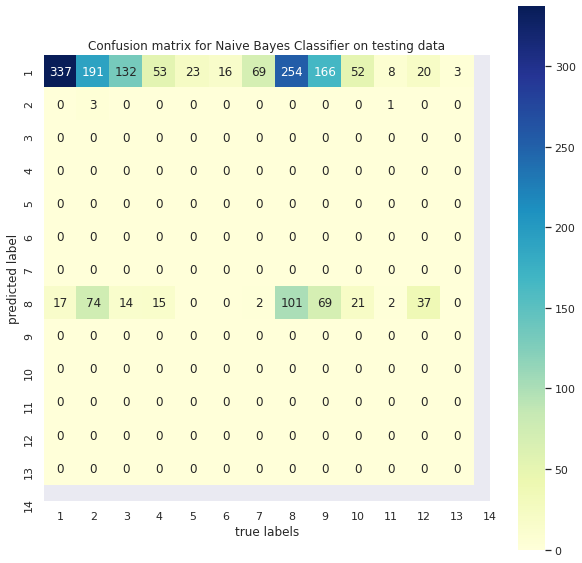

Naive Bayes Classifier test Score ->  26.25
Classification report for Naive Bayes Classifier on testing data:
              precision    recall  f1-score   support

           1       0.25      0.95      0.40       354
           2       0.75      0.01      0.02       268
           3       1.00      0.00      0.00       146
           4       1.00      0.00      0.00        68
           5       1.00      0.00      0.00        23
           6       1.00      0.00      0.00        16
           7       1.00      0.00      0.00        71
           8       0.29      0.28      0.29       355
           9       1.00      0.00      0.00       235
          10       1.00      0.00      0.00        73
          11       1.00      0.00      0.00        11
          12       1.00      0.00      0.00        57
          13       1.00      0.00      0.00         3
          14       1.00      1.00      1.00         0

   micro avg       0.26      0.26      0.26      1680
   macro avg       0.88 

<Figure size 432x288 with 0 Axes>

In [ ]:
scotus_naive_bayes(lda_X_train, lda_y_train, lda_X_val, lda_y_val)
scotus_naive_bayes(lda_X_train,lda_y_train, lda_X_test, lda_y_test, val=False)

Logistic Regression validation Score ->  35.9375


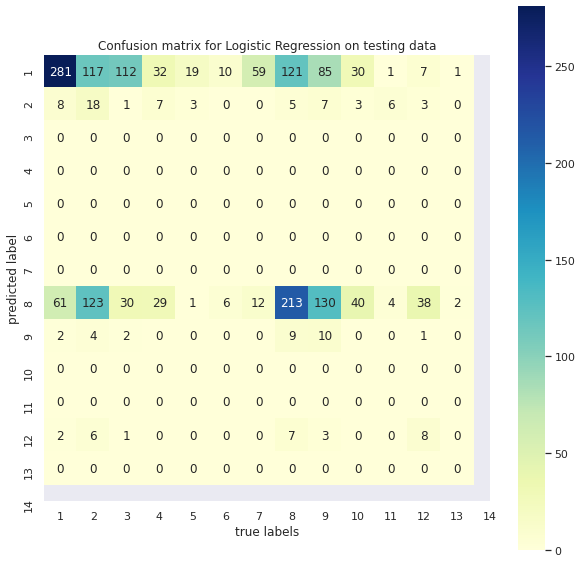

Logistic Regression test Score ->  31.547619047619047
Classification report for Logistic Regression on testing data:
              precision    recall  f1-score   support

           1       0.32      0.79      0.46       354
           2       0.30      0.07      0.11       268
           3       1.00      0.00      0.00       146
           4       1.00      0.00      0.00        68
           5       1.00      0.00      0.00        23
           6       1.00      0.00      0.00        16
           7       1.00      0.00      0.00        71
           8       0.31      0.60      0.41       355
           9       0.36      0.04      0.08       235
          10       1.00      0.00      0.00        73
          11       1.00      0.00      0.00        11
          12       0.30      0.14      0.19        57
          13       1.00      0.00      0.00         3
          14       1.00      1.00      1.00         0

   micro avg       0.32      0.32      0.32      1680
   macro avg     

<Figure size 432x288 with 0 Axes>

In [ ]:
scotus_logistic_regresiion(lda_X_train,lda_y_train, lda_X_val, lda_y_val)
scotus_logistic_regresiion(lda_X_train,lda_y_train, lda_X_test, lda_y_test, val=False)

Random Forest Classifier validation Score ->  26.339285714285715


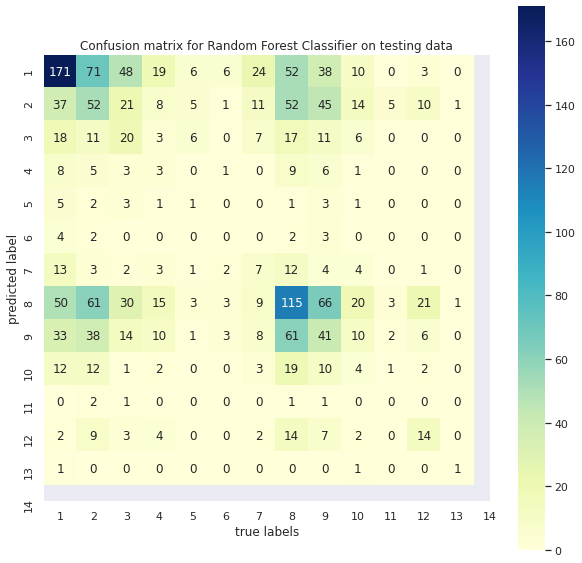

Random Forest Classifier test Score ->  25.535714285714285
Classification report for Random Forest Classifier on testing data:
              precision    recall  f1-score   support

           1       0.38      0.48      0.43       354
           2       0.20      0.19      0.20       268
           3       0.20      0.14      0.16       146
           4       0.08      0.04      0.06        68
           5       0.06      0.04      0.05        23
           6       0.00      0.00      0.00        16
           7       0.13      0.10      0.11        71
           8       0.29      0.32      0.31       355
           9       0.18      0.17      0.18       235
          10       0.06      0.05      0.06        73
          11       0.00      0.00      0.00        11
          12       0.25      0.25      0.25        57
          13       0.33      0.33      0.33         3
          14       1.00      1.00      1.00         0

   micro avg       0.26      0.26      0.26      1680
   macr

<Figure size 432x288 with 0 Axes>

In [ ]:
scotus_rf(lda_X_train,lda_y_train, lda_X_val, lda_y_val)
scotus_rf(lda_X_train,lda_y_train, lda_X_test, lda_y_test, val=False)

SVM validation Score ->  36.01190476190476


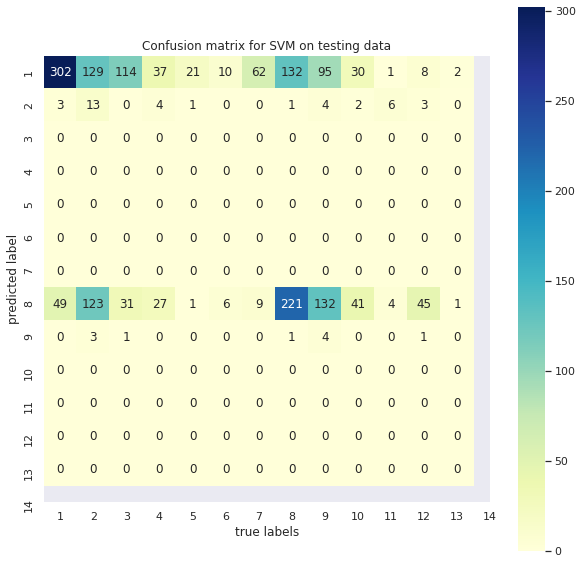

SVM test Score ->  32.142857142857146
Classification report for SVM on testing data:
              precision    recall  f1-score   support

           1       0.32      0.85      0.47       354
           2       0.35      0.05      0.09       268
           3       1.00      0.00      0.00       146
           4       1.00      0.00      0.00        68
           5       1.00      0.00      0.00        23
           6       1.00      0.00      0.00        16
           7       1.00      0.00      0.00        71
           8       0.32      0.62      0.42       355
           9       0.40      0.02      0.03       235
          10       1.00      0.00      0.00        73
          11       1.00      0.00      0.00        11
          12       1.00      0.00      0.00        57
          13       1.00      0.00      0.00         3
          14       1.00      1.00      1.00         0

   micro avg       0.32      0.32      0.32      1680
   macro avg       0.81      0.18      0.14      

<Figure size 432x288 with 0 Axes>

In [ ]:
scotus_svm(lda_X_train, lda_y_train, lda_X_val, lda_y_val)
scotus_svm(lda_X_train,lda_y_train, lda_X_test, lda_y_test, val=False)

### TFIDF + Classifiers

Naive Bayes Classifier validation Score ->  61.38392857142857


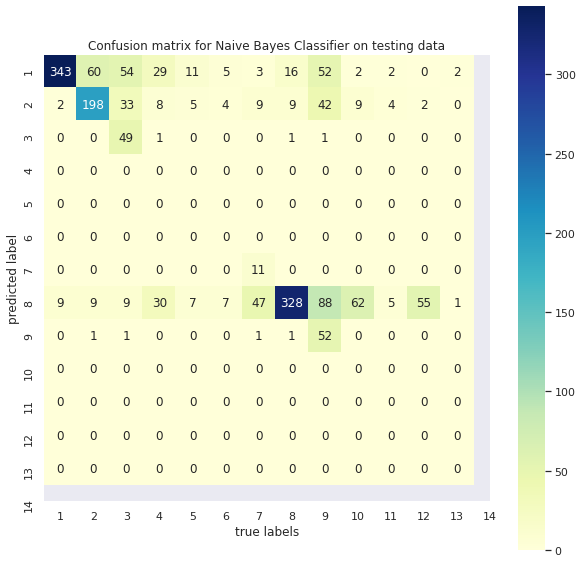

Naive Bayes Classifier test Score ->  58.392857142857146
Classification report for Naive Bayes Classifier on testing data:
              precision    recall  f1-score   support

           1       0.59      0.97      0.74       354
           2       0.61      0.74      0.67       268
           3       0.94      0.34      0.49       146
           4       1.00      0.00      0.00        68
           5       1.00      0.00      0.00        23
           6       1.00      0.00      0.00        16
           7       1.00      0.15      0.27        71
           8       0.50      0.92      0.65       355
           9       0.93      0.22      0.36       235
          10       1.00      0.00      0.00        73
          11       1.00      0.00      0.00        11
          12       1.00      0.00      0.00        57
          13       1.00      0.00      0.00         3
          14       1.00      1.00      1.00         0

   micro avg       0.58      0.58      0.58      1680
   macro av

<Figure size 432x288 with 0 Axes>

In [ ]:
scotus_naive_bayes(tfidf_X_train, tfidf_y_train, tfidf_X_val, tfidf_y_val)
scotus_naive_bayes(tfidf_X_train, tfidf_y_train, tfidf_X_test, tfidf_y_test, val=False)

Logistic Regression validation Score ->  75.81845238095238


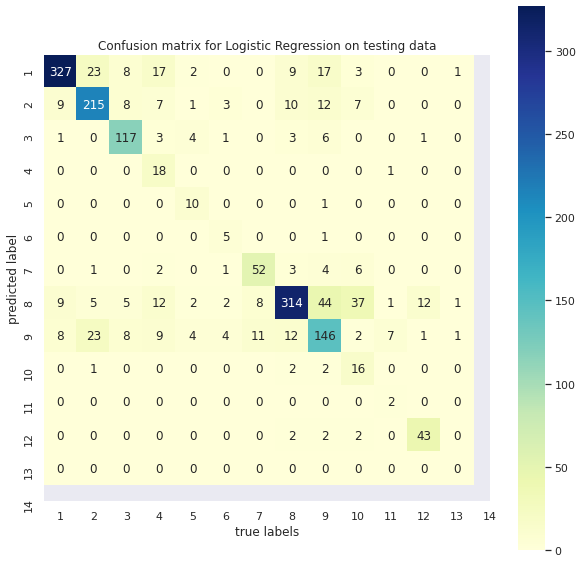

Logistic Regression test Score ->  75.29761904761905
Classification report for Logistic Regression on testing data:
              precision    recall  f1-score   support

           1       0.80      0.92      0.86       354
           2       0.79      0.80      0.80       268
           3       0.86      0.80      0.83       146
           4       0.95      0.26      0.41        68
           5       0.91      0.43      0.59        23
           6       0.83      0.31      0.45        16
           7       0.75      0.73      0.74        71
           8       0.69      0.88      0.78       355
           9       0.62      0.62      0.62       235
          10       0.76      0.22      0.34        73
          11       1.00      0.18      0.31        11
          12       0.88      0.75      0.81        57
          13       1.00      0.00      0.00         3
          14       1.00      1.00      1.00         0

   micro avg       0.75      0.75      0.75      1680
   macro avg      

<Figure size 432x288 with 0 Axes>

In [ ]:
scotus_logistic_regresiion(tfidf_X_train, tfidf_y_train, tfidf_X_val, tfidf_y_val)
scotus_logistic_regresiion(tfidf_X_train, tfidf_y_train, tfidf_X_test, tfidf_y_test, val=False)

Random Forest Classifier validation Score ->  68.00595238095238


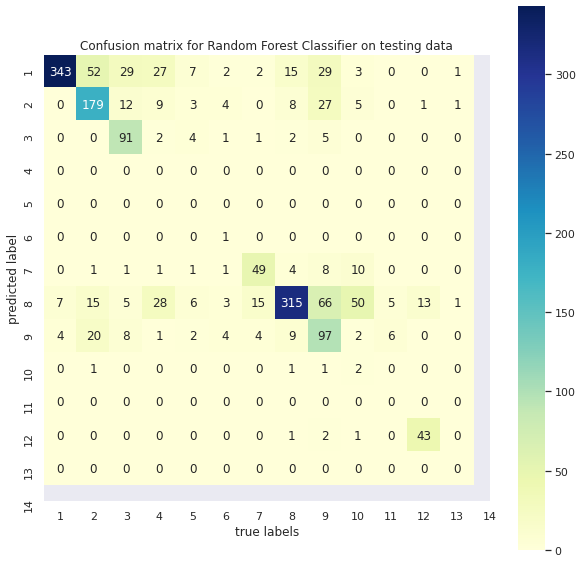

Random Forest Classifier test Score ->  66.66666666666666
Classification report for Random Forest Classifier on testing data:
              precision    recall  f1-score   support

           1       0.67      0.97      0.79       354
           2       0.72      0.67      0.69       268
           3       0.86      0.62      0.72       146
           4       1.00      0.00      0.00        68
           5       1.00      0.00      0.00        23
           6       1.00      0.06      0.12        16
           7       0.64      0.69      0.67        71
           8       0.60      0.89      0.71       355
           9       0.62      0.41      0.49       235
          10       0.40      0.03      0.05        73
          11       1.00      0.00      0.00        11
          12       0.91      0.75      0.83        57
          13       1.00      0.00      0.00         3
          14       1.00      1.00      1.00         0

   micro avg       0.67      0.67      0.67      1680
   macro

<Figure size 432x288 with 0 Axes>

In [ ]:
scotus_rf(tfidf_X_train, tfidf_y_train, tfidf_X_val, tfidf_y_val)
scotus_rf(tfidf_X_train, tfidf_y_train, tfidf_X_test, tfidf_y_test, val=False)

SVM validation Score ->  77.90178571428571


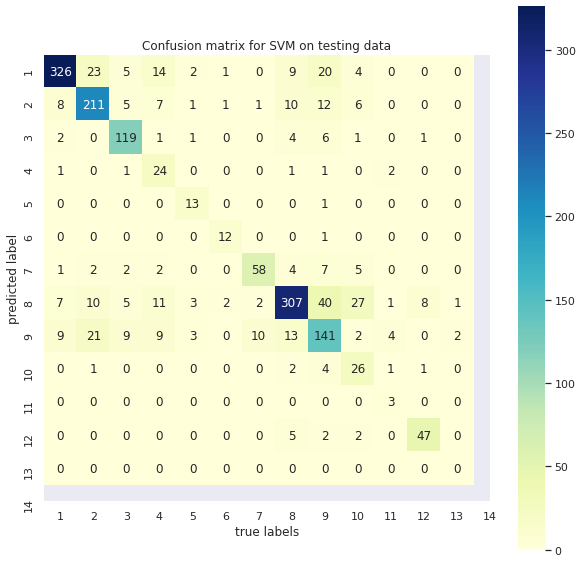

SVM test Score ->  76.60714285714286
Classification report for SVM on testing data:
              precision    recall  f1-score   support

           1       0.81      0.92      0.86       354
           2       0.81      0.79      0.80       268
           3       0.88      0.82      0.85       146
           4       0.80      0.35      0.49        68
           5       0.93      0.57      0.70        23
           6       0.92      0.75      0.83        16
           7       0.72      0.82      0.76        71
           8       0.72      0.86      0.79       355
           9       0.63      0.60      0.62       235
          10       0.74      0.36      0.48        73
          11       1.00      0.27      0.43        11
          12       0.84      0.82      0.83        57
          13       1.00      0.00      0.00         3
          14       1.00      1.00      1.00         0

   micro avg       0.77      0.77      0.77      1680
   macro avg       0.84      0.64      0.67      1

<Figure size 432x288 with 0 Axes>

In [ ]:
scotus_svm(tfidf_X_train, tfidf_y_train, tfidf_X_val, tfidf_y_val)
scotus_svm(tfidf_X_train, tfidf_y_train, tfidf_X_test, tfidf_y_test, val=False)

In [ ]:
# Refererence:
# LDA: https://towardsdatascience.com/topic-modeling-and-latent-dirichlet-allocation-in-python-9bf156893c24
# SVM: https://medium.com/@bedigunjit/simple-guide-to-text-classification-nlp-using-svm-and-naive-bayes-with-python-421db3a72d34
# gensim: https://statsmaths.github.io/stat289-f18/solutions/tutorial19-gensim.html